In [6]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platforms", 'cpu')

from ImageD11.unitcell import unitcell
from ImageD11.parameters import AnalysisSchema
from ImageD11.columnfile import columnfile

In [50]:
pars = AnalysisSchema.from_default(detector='frelon').geometry_pars_obj

In [51]:
pars.get_parameters()

{'chi': 0.0,
 'distance': 136062.54166078364,
 'fit_tolerance': 0.05,
 'min_bin_prob': 1e-05,
 'no_bins': 10000,
 'o11': 1,
 'o12': 0,
 'o21': 0,
 'o22': -1,
 'omegasign': 1.0,
 't_x': 0.0,
 't_y': 0.0,
 't_z': 0.0,
 'tilt_x': 0.0,
 'tilt_y': 0.0,
 'tilt_z': 0.0,
 'wavelength': 0.28457041,
 'wedge': 0.0,
 'weight_hist_intensities': 0,
 'y_center': 1081.849909211387,
 'y_size': 47.0,
 'z_center': 1017.0452628833956,
 'z_size': 47.0}

In [45]:
ref_ucell = unitcell([2.8, 2.8, 2.8, 90, 90, 90], 229)  # BCC Fe

In [46]:
ref_ucell.makerings(3.0)
hkls = []
mults = []
for i, d in enumerate(ref_ucell.ringds):
    hklring = ref_ucell.ringhkls[d]
    mults.append( len(hklring) )
    print(i, len(hklring),hklring[0],d)
    hkls += list(hklring)

hkls = np.array(hkls)

0 12 (-1, 0, -1) 0.5050762722761054
1 6 (0, -2, 0) 0.7142857142857144
2 24 (-2, -1, -1) 0.8748177652797067
3 12 (-2, -2, 0) 1.0101525445522108
4 24 (0, -1, -3) 1.1293848786315641
5 8 (-2, -2, -2) 1.237179148263484
6 48 (-1, -2, -3) 1.336306209562122
7 6 (0, -4, 0) 1.4285714285714288
8 36 (-1, -1, -4) 1.5152288168283161
9 24 (-4, -2, 0) 1.59719141249985
10 24 (-3, -3, -2) 1.675148485651225
11 24 (-4, -2, -2) 1.7496355305594133
12 72 (-4, -3, -1) 1.821078397711709
13 48 (-2, -5, -1) 1.9561519910898792
14 12 (-4, 0, -4) 2.0203050891044216
15 48 (-3, 0, -5) 2.0824828195876073
16 30 (0, 0, -6) 2.142857142857143
17 72 (-5, -2, -3) 2.2015764296317775
18 24 (-2, 0, -6) 2.2587697572631282
19 48 (-1, -5, -4) 2.3145502494313788
20 24 (-2, -6, -2) 2.3690177073967145
21 48 (-6, -3, -1) 2.4222607082590244
22 8 (-4, -4, -4) 2.474358296526968
23 84 (-5, 0, -5) 2.525381361380527
24 24 (-6, 0, -4) 2.575393768188564
25 96 (-3, -3, -6) 2.6244532958391193
26 48 (-4, -6, -2) 2.672612419124244
27 24 (-3, 0, 

In [332]:
from scipy.spatial.transform import Rotation as R

ng = 100

U = R.random(ng).as_matrix()

U.shape

(100, 3, 3)

In [333]:
UB = U @ ref_ucell.B

In [334]:
gves = (UB @ hkls.T).transpose(2, 0, 1)
gves.shape

(1252, 100, 3)

In [335]:
import transform as mytrans

In [349]:
import importlib
importlib.reload(mytrans)

<module 'transform' from '/home/esrf/james1997a/Code/Anri/anri/sandbox/transform.py'>

In [337]:
pars.set('distance', 130e3)  # 130 mm
pars.set('wavelength', 0.1771)
pars.set('y_center', 1024)
pars.set('z_center', 1024)

In [354]:
# get max observable ds
# detector corner pixel -> tth

tth, eta = mytrans.det_to_tth_eta(np.array([2048]), np.array([2048]), np.array([0]), np.array([0., 0., 0.]), pars.get('wedge'), pars.get('chi'),
                                                                 pars.get('y_center'), pars.get('y_size'), pars.get('tilt_y'),
                                                                 pars.get('z_center'), pars.get('z_size'), pars.get('tilt_z'),
                                                                 pars.get('tilt_x'),
                                                                 pars.get('distance'),
                                                                 pars.get('o11'), pars.get('o12'), pars.get('o21'),pars.get('o22'))

In [ ]:
mytrans.det

In [355]:
tth

Array([27.63491835], dtype=float64)

In [356]:
import Dans_Diffraction as dd

In [363]:
dsmax = 1/dd.functions_crystallography.caldspace(tth, wavelength_a=pars.get('wavelength'))
dsmax

array([2.69711316])

In [365]:
dd.functions_crystallography.calqmag??

Signature:
dd.functions_crystallography.calqmag(
    twotheta,
    energy_kev=17.794,
    wavelength_a=None,
)
Source:   
def calqmag(twotheta, energy_kev=17.794, wavelength_a=None):
    """
    Calculate |Q| at a particular 2-theta (deg) for energy in keV
      magQ = calqmag(twotheta, energy_kev=17.794)
       - equivalent to -
      qmag = 4 * pi * sin(theta) / wl

    :param twotheta: float or array of scattering angles, in degrees
    :param energy_kev: float photon energy in keV
    :param wavelength_a: float wavelength in Anstrom
    :return wavevector magnitude in inverse-Angstrom
    """
    if wavelength_a is None:
        wavelength_a = energy2wave(energy_kev)  # wavelength form photon energy
    # energy = energy_kev * 1000.0  # energy in eV
    theta = twotheta * np.pi / 360  # theta in radians
    # Calculate |Q|
    # magq = 4pi sin(theta) / lambda
    # magq = np.sin(theta) * energy * fg.e * 4 * np.pi / (fg.h * fg.c * 1e10)
    magq = np.sin(theta) * 4 * np.pi / wavelen

In [338]:
tx = np.random.random(ng) * 1000 - 500
ty = np.random.random(ng) * 1000 - 500
tz = np.random.random(ng) * 100 - 50

In [339]:
origin_sample = np.column_stack((tx, ty, tz))
origin_sample.shape

(100, 3)

In [340]:
origin_sample = np.broadcast_to(origin_sample, gves.shape)
origin_sample.shape

(1252, 100, 3)

In [341]:
gves = gves.reshape(-1, 3)
origin_sample = origin_sample.reshape(-1, 3)

In [342]:
(sc1, fc1), (sc2, fc2), (omega1, omega2), valid = mytrans.g_to_det(gves, origin_sample,
                                                                    pars.get('wedge'), pars.get('chi'), pars.get('wavelength'),
                                                                    pars.get('y_center'), pars.get('y_size'), pars.get('tilt_y'),
                                                                    pars.get('z_center'), pars.get('z_size'), pars.get('tilt_z'),
                                                                    pars.get('tilt_x'),
                                                                    pars.get('distance'),
                                                                    pars.get('o11'), pars.get('o12'), pars.get('o21'),pars.get('o22'))

In [343]:
sc = np.concatenate((sc1[valid], sc2[valid]))
fc = np.concatenate((fc1[valid], fc2[valid]))
omega = np.concatenate((omega1[valid], omega2[valid]))

In [ ]:
# histogram 

In [346]:
m = (sc > 0) & (sc < 2048) & (fc > 0) & (fc < 2048)

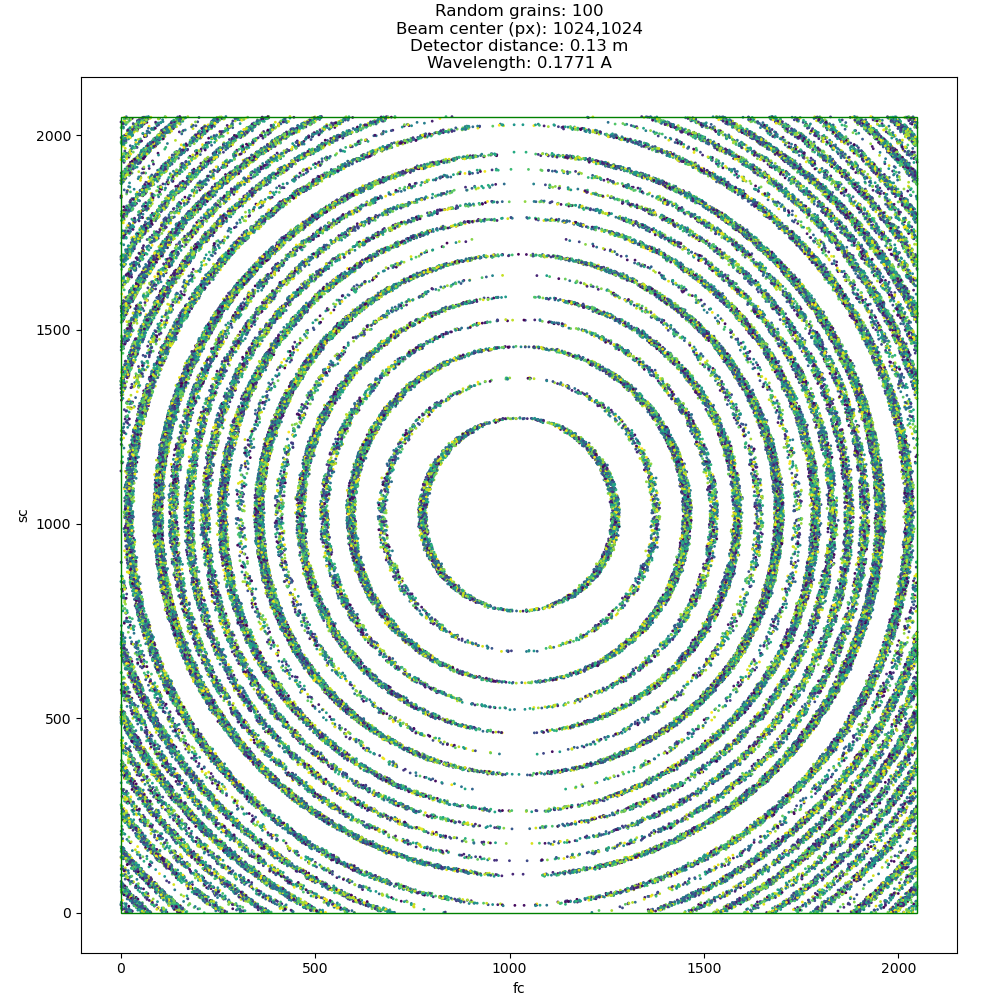

In [348]:
from matplotlib import pyplot as plt
%matplotlib ipympl

fig, ax = plt.subplots(constrained_layout=True, figsize=(10,10))
ax.scatter(fc[m], sc[m], s=1, c=omega[m])
from matplotlib import patches
rect = patches.Rectangle((0, 0), 2048, 2048, linewidth=1, edgecolor='green', facecolor='none')
ax.add_patch(rect)
ax.set_aspect(1)
ax.set(xlabel='fc', ylabel='sc',
       title=f"""Random grains: {ng}
Beam center (px): {pars.get('y_center')},{pars.get('z_center')}
Detector distance: {pars.get('distance')/1e6:.4} m
Wavelength: {pars.get('wavelength'):.4} A""")
plt.show()

In [ ]:
nrows = 100_000

fc = np.random.random(nrows) * 2048
sc = np.random.random(nrows) * 2048
om = np.random.random(nrows) * 360

In [ ]:
cf = columnfile(new=True)
cf.nrows = nrows

cf.addcolumn(fc, 'fc')
cf.addcolumn(sc, 'sc')
cf.addcolumn(om, 'omega')

In [ ]:
cf.parameters = pars

In [ ]:
cf.updateGeometry()

In [ ]:
cf.titles

In [ ]:
gvecs = np.column_stack([cf.gx, cf.gy, cf.gz])

In [ ]:
import ImageD11.transform, ImageD11.gv_general

In [ ]:
import transform as mytrans

In [ ]:
import importlib
importlib.reload(mytrans)

# Full pipeline test: sc, fc, omega, origins (zeroes for now) to g-vectors

In [ ]:
gvecs_me = mytrans.det_to_g(cf.sc, cf.fc, cf.omega, jnp.array((pars.get('t_x'), pars.get('t_y'), pars.get('t_z'))),
                            pars.get('wedge'), pars.get('chi'), pars.get('wavelength'),
                            pars.get('y_center'), pars.get('y_size'), pars.get('tilt_y'),
                                              pars.get('z_center'), pars.get('z_size'), pars.get('tilt_z'),
                                              pars.get('tilt_x'),
                                              pars.get('distance'),
                                              pars.get('o11'), pars.get('o12'), pars.get('o21'),pars.get('o22'), )

In [ ]:
gvecs_me

In [ ]:
gvecs

In [ ]:
assert np.allclose(gvecs_me, gvecs)

# Lab <-> Detector

In [ ]:
%%time

xyz_id11 = ImageD11.transform.compute_xyz_lab((cf.sc, cf.fc), **pars.parameters)

In [ ]:
%%time

xyz_me = mytrans.det_to_xyz_lab(cf.sc, cf.fc, pars.get('y_center'), pars.get('y_size'), pars.get('tilt_y'),
                                              pars.get('z_center'), pars.get('z_size'), pars.get('tilt_z'),
                                              pars.get('tilt_x'),
                                              pars.get('distance'),
                                              pars.get('o11'), pars.get('o12'), pars.get('o21'),pars.get('o22'))

In [ ]:
assert np.allclose(xyz_id11.T, xyz_me)

In [ ]:
v_det_me = mytrans.xyz_lab_to_det(cf.xl, cf.yl, cf.zl,
                                  pars.get('y_center'), pars.get('y_size'), pars.get('tilt_y'),
                                              pars.get('z_center'), pars.get('z_size'), pars.get('tilt_z'),
                                              pars.get('tilt_x'),
                                              pars.get('distance'),
                                              pars.get('o11'), pars.get('o12'), pars.get('o21'),pars.get('o22'))

In [ ]:
assert np.allclose(v_det_me[:, 0], cf.sc)
assert np.allclose(v_det_me[:, 1], cf.fc)

# Lab <-> tth, eta, omega

In [ ]:
tth_id11, eta_id11 = ImageD11.transform.compute_tth_eta_from_xyz(np.stack((cf.xl, cf.yl, cf.zl)), cf.omega, **pars.parameters)

In [ ]:
tth_me, eta_me = mytrans.xyz_lab_to_tth_eta(jnp.column_stack((cf.xl, cf.yl, cf.zl)), cf.omega, jnp.array((pars.get('t_x'), pars.get('t_y'), pars.get('t_z'))), pars.get('wedge'), pars.get('chi'))

In [ ]:
assert np.allclose(tth_me, tth_id11)
assert np.allclose(eta_me, eta_id11)

In [ ]:
fc_id11, sc_id11 = ImageD11.transform.compute_xyz_from_tth_eta(cf.tth, cf.eta, cf.omega, **pars.parameters)

In [ ]:
assert np.allclose(fc_id11, cf.fc)
assert np.allclose(sc_id11, cf.sc)

In [ ]:
sc_me, fc_me = mytrans.tth_eta_omega_to_det(cf.tth, cf.eta, cf.omega, jnp.array((pars.get('t_x'), pars.get('t_y'), pars.get('t_z'))),
                                          pars.get('wedge'), pars.get('chi'),  pars.get('wavelength'),
                                          pars.get('y_center'), pars.get('y_size'), pars.get('tilt_y'),
                                          pars.get('z_center'), pars.get('z_size'), pars.get('tilt_z'),
                                          pars.get('tilt_x'),
                                          pars.get('distance'),
                                          pars.get('o11'), pars.get('o12'), pars.get('o21'),pars.get('o22'))

In [ ]:
assert np.allclose(sc_me, cf.sc)
assert np.allclose(fc_me, cf.fc)

In [ ]:

dxyzl = mytrans.det_to_xyz_lab(sc, fc, pars.get('y_center'), pars.get('y_size'), pars.get('tilt_y'),
                                              pars.get('z_center'), pars.get('z_size'), pars.get('tilt_z'),
                                              pars.get('tilt_x'),
                                              pars.get('distance'),
                                              pars.get('o11'), pars.get('o12'), pars.get('o21'),pars.get('o22'))

In [ ]:
dxyzl.shape

In [ ]:
t_id11 = ImageD11.transform.compute_grain_origins(cf.omega, pars.get('wedge'), pars.get('chi'), cf.xl, cf.yl, cf.zl)

In [ ]:
t_me = mytrans.sample_to_lab(np.column_stack((cf.xl, cf.yl, cf.zl)), cf.omega, pars.get('wedge'), pars.get('chi'))

In [ ]:
assert np.allclose(t_id11, t_me.T)

In [ ]:
%%time

tth_id11, (eta1_id11, eta2_id11), (omega1_id11, omega2_id11) = ImageD11.transform.uncompute_g_vectors(gvecs.T, pars.get('wavelength'), pars.get('wedge'), pars.get('chi'))

In [ ]:
%%time

tth_me, (eta1_me, eta2_me), (omega1_me, omega2_me) = mytrans.g_to_tth_eta_omega(gvecs, pars.get('wedge'), pars.get('chi'), pars.get('wavelength'), )

In [ ]:
assert np.allclose(tth_id11, tth_me)
assert np.allclose(eta1_id11, eta1_me)
assert np.allclose(eta2_id11, eta2_me)
assert np.allclose(omega1_id11, omega1_me)
assert np.allclose(omega2_id11, omega2_me)

In [ ]:
t_id11 = ImageD11.transform.compute_grain_origins(cf.omega, pars.get('wedge'), pars.get('chi'), cf.xl, cf.yl, cf.zl)

In [ ]:
t_me = mytrans.sample_to_lab(np.column_stack((cf.xl, cf.yl, cf.zl)), cf.omega, pars.get('wedge'), pars.get('chi'))

In [ ]:
t_id11.shape

In [ ]:
t_me.shape

In [ ]:
assert np.allclose(t_id11, t_me.T)

In [ ]:
%%time

tth_id11, (eta1_id11, eta2_id11), (omega1_id11, omega2_id11) = ImageD11.transform.uncompute_g_vectors(gvecs.T, pars.get('wavelength'), pars.get('wedge'), pars.get('chi'))

In [ ]:
tth_id11

In [ ]:
%%time

tth_me, (eta1_me, eta2_me), (omega1_me, omega2_me) = mytrans.g_to_tth_eta_omega(gvecs, pars.get('wedge'), pars.get('chi'), pars.get('wavelength'))

In [ ]:
tth_me

In [ ]:
assert np.allclose(tth_id11, tth_me)
assert np.allclose(eta1_id11, eta1_me)
assert np.allclose(eta2_id11, eta2_me)
assert np.allclose(omega1_id11, omega1_me)
assert np.allclose(omega2_id11, omega2_me)

In [ ]:
eta1_me

In [ ]:
eta1_id11

In [ ]:
# test k vector computation
k_id11 = ImageD11.transform.compute_k_vectors(cf.tth, cf.eta, pars.get('wavelength'))

In [ ]:
k_id11

In [ ]:
k_me = mytrans.tth_eta_to_k(cf.tth, cf.eta, pars.get('wavelength'))

In [ ]:
k_me

In [ ]:
k_id11.shape

In [ ]:
k_me.shape

In [ ]:
assert np.allclose(k_id11.T, k_me)

In [ ]:
# test computation of angles for g-vectors

W =  mytrans.wedgemat(pars.get('wedge'))
C =  mytrans.chimat(pars.get('chi'))
pre = (C @ W).T

oms_id11 = ImageD11.gv_general.g_to_k(gvecs.T, pars.get('wavelength'), axis=[0,0,1], pre=pre, post=None)

In [ ]:
oms_id11

In [ ]:
oms_me = mytrans.omega_solns_for_g(gvecs, pars.get('wavelength'), np.array([0,0,1]), pre, jnp.eye(3))

In [ ]:
oms_me

In [ ]:
assert np.allclose(oms_id11[0], oms_me[0])
assert np.allclose(oms_id11[1], oms_me[1])
assert np.allclose(oms_id11[2], oms_me[2])

In [ ]:
# now use k vectors to test g_from_k

In [ ]:
# test k vector computation
k_id11 = ImageD11.transform.compute_k_vectors(cf.tth, cf.eta, pars.get('wavelength'))
g_id11 = ImageD11.transform.compute_g_from_k(k_id11, cf.omega, pars.get('wedge'), pars.get('chi'))

In [ ]:
g_id11

In [ ]:
g_me = mytrans.lab_to_sample(k_id11.T, cf.omega, pars.get('wedge'), pars.get('chi'))

In [ ]:
g_me

In [ ]:
assert np.allclose(g_id11.T, g_me)

In [ ]:
g_id11_trans = ImageD11.transform.compute_g_from_k(k_id11, cf.omega, pars.get('wedge'), pars.get('chi'))

In [ ]:
g_id11_trans

In [ ]:
# C @ W -Z works

W =  mytrans.wedgemat(pars.get('wedge'))
C =  mytrans.chimat(pars.get('chi'))

post = C @ W

g_id11_gvgeneral = ImageD11.gv_general.k_to_g(k_id11, cf.omega, axis=np.array([0., 0., -1]), pre=None, post=post)

In [ ]:
g_id11_gvgeneral

In [ ]:
assert np.allclose(g_id11_trans, g_id11_gvgeneral)

In [ ]:
g_id11 = ImageD11.transform.compute_g_vectors(cf.tth, cf.eta, cf.omega, pars.get('wavelength'), pars.get('wedge'), pars.get('chi'))

In [ ]:
g_id11

In [ ]:
assert np.allclose(gvecs, g_id11.T)

In [ ]:
g_me = mytrans.tth_eta_omega_to_g(cf.tth, cf.eta, cf.omega,  pars.get('wedge'), pars.get('chi'), pars.get('wavelength'),)

In [ ]:
g_me

In [ ]:
assert np.allclose(gvecs, g_me)

In [ ]:
assert np.allclose(gvecs, mytrans.sample_to_lab(mytrans.lab_to_sample(gvecs, cf.omega, pars.get('wedge'), pars.get('chi')), cf.omega, pars.get('wedge'), pars.get('chi')))

In [ ]:
# g-vectors to (tth, eta, omega)
tth, [eta_one, eta_two], [omega1, omega2] = mytrans.g_to_tth_eta_omega(gvecs, pars.get('wedge'), pars.get('chi'), pars.get('wavelength'), )

In [ ]:
assert np.allclose(tth, cf.tth)
assert all(np.logical_or(np.isclose(cf.eta, eta_one), np.isclose(cf.eta, eta_two)))
assert all(np.logical_or(np.isclose(cf.omega, omega1 % 360), np.isclose(cf.omega, omega2 % 360)))

In [ ]:
# (tth, eta, omega) to g-vectors
gvecs_loop = mytrans.tth_eta_omega_to_g(tth, eta_one, omega1, pars.get('wedge'), pars.get('chi'), pars.get('wavelength'), )
assert np.allclose(gvecs_loop, gvecs)

In [ ]:
# (tth, eta, omega) to g-vectors
gvecs_loop = mytrans.tth_eta_omega_to_g(tth, eta_two, omega2, pars.get('wedge'), pars.get('chi'), pars.get('wavelength'), )
assert np.allclose(gvecs_loop, gvecs)

In [ ]:
k_me = mytrans.xyz_lab_to_k(np.column_stack((cf.xl, cf.yl, cf.zl)), cf.omega, jnp.array((pars.get('t_x'), pars.get('t_y'), pars.get('t_z'))), pars.get('wedge'), pars.get('chi'), pars.get('wavelength'))

In [ ]:
k_me

In [ ]:
sc_me, fc_me = mytrans.k_to_det(k_me, cf.omega, jnp.array((pars.get('t_x'), pars.get('t_y'), pars.get('t_z'))), pars.get('wedge'), pars.get('chi'), pars.get('wavelength'), pars.get('y_center'), pars.get('y_size'), pars.get('tilt_y'),
                                              pars.get('z_center'), pars.get('z_size'), pars.get('tilt_z'),
                                              pars.get('tilt_x'),
                                              pars.get('distance'),
                                              pars.get('o11'), pars.get('o12'), pars.get('o21'),pars.get('o22'))

In [ ]:
sc_me

In [ ]:
xyz_me = mytrans.k_to_xyz_lab(k_me, cf.omega, jnp.array((pars.get('t_x'), pars.get('t_y'), pars.get('t_z'))), pars.get('wedge'), pars.get('chi'), pars.get('wavelength'), pars.get('y_center'), pars.get('y_size'), pars.get('tilt_y'),
                                              pars.get('z_center'), pars.get('z_size'), pars.get('tilt_z'),
                                              pars.get('tilt_x'),
                                              pars.get('distance'),
                                              pars.get('o11'), pars.get('o12'), pars.get('o21'),pars.get('o22'))

In [ ]:
assert np.allclose(xyz_me, np.column_stack((cf.xl, cf.yl, cf.zl)))

In [ ]:
xyz_me